## 1. Project
Sparkify is a virtual company that mimics other music streaming services similar to Spotify or Google Music. The dataset Sparkify has provided, contains a user behavior log from October to November 2018. The main idea of this Sparkify project is to create a machine learning model that can predict churned users. This project is a part of Udacity's Data Scientist Nanodegree program. The main idea of this Sparkify project is to create a machine learning model that can predict churned users. This project is a part of Udacity's Data Scientist Nanodegree program.
 
The assignment was to build a model to predict user churn. Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business.


In [2]:
# cheking the drivers memory, decided to try with this without any
# configurations, which would cause installing issues
spark.sparkContext.getConf().get('spark.driver.memory')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1611139082886_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2048M'

In [3]:
%%configure -f
{ "conf":{
          "spark.pyspark.python" : "python3",
          "spark.pyspark.virtualenv.enabled" : "true",
          "spark.pyspark.virtualenv.type" : "native",
          "spark.pyspark.virtualenv.bin.path" : "/usr/bin/virtualenv"
         }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1611139082886_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1611139082886_0002,pyspark,idle,Link,Link,✔


In [4]:
# installing needed python packages for visuals and testing
sc.install_pypi_package('pandas', 'https://pypi.org/simple') 
sc.install_pypi_package('matplotlib', 'https://pypi.org/simple') 
sc.install_pypi_package('seaborn', 'https://pypi.org/simple') 
sc.install_pypi_package('statsmodels', 'https://pypi.org/simple')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# import libraries

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import *
from pyspark.sql.types import *


import pyspark.sql.functions as F

import datetime
import time
from pyspark.sql.functions import date_format


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# create a spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2. Load and Clean Dataset and Data Understanding

In [124]:
# load dataset
event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
df = spark.read.json(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|  Popol Vuh|Logged In|    Shlok|     M|          278| Johnson|524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|Los Bunkers|Logged In|  Vianney|     F|            9|  Miller|238.39302| paid|San Francisco-Oak...|   PUT|NextSong|1537500318000|    20836|         MiÃ

In [9]:
print(f'Total rows: {df.count():,}'), print('Total columns {}'.format(len(df.columns)));

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total rows: 26,259,199
Total columns 18
(None, None)

In [10]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [11]:
#checking missing values 
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408927|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

I found out during the EDA process, that missing values were quite tricky. If you drop all missing values at once, the whole dataset will lose main information. Also, when preprocessed with the mini dataset in Udacity's workspace, it did not have these rows which caused issues in the full dataset. If your code worked with the mini dataset, it did not work with the full dataset. So it was very tedious and cost full to debug your code in AWS console.

The gender column had some missing values that caused issues with the full dataset so they should be cleaned. 

There are also the same null values in artist, song, and length columns. These I will process when creating a features data frame later on. 

Next, I will show you the deducting of what happens if drop all null values in the cleaning phase.

In [12]:
# customers events
df.select('page').dropDuplicates().sort('page').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

In [13]:
# find userId's that have cancelled
df.filter("page = 'Cancellation Confirmation'").show(n=2, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------
 artist        | null                 
 auth          | Cancelled            
 firstName     | Harrison             
 gender        | M                    
 itemInSession | 32                   
 lastName      | Turner               
 length        | null                 
 level         | paid                 
 location      | Dayton, OH           
 method        | GET                  
 page          | Cancellation Conf... 
 registration  | 1536683985000        
 sessionId     | 24588                
 song          | null                 
 status        | 200                  
 ts            | 1538360145000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 1768454              
-RECORD 1-----------------------------
 artist        | null                 
 auth          | Cancelled            
 firstName     | Andrew               
 gender        | M                    
 itemInSession | 16                   
 lastName      | Lutz    

In [128]:
# showing canceled customer events and null values
df.select(['userId', 'level','page','artist', 'song', 'length']).where(df.userId == '1768454').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+----------+-------------------+--------------------+---------+
| userId|level|      page|             artist|                song|   length|
+-------+-----+----------+-------------------+--------------------+---------+
|1768454| paid|      Home|               null|                null|     null|
|1768454| paid|  NextSong|         The Police|Don't Stand So Cl...|291.44771|
|1768454| paid|  NextSong|       Keyshia Cole|         We Could Be|191.00689|
|1768454| paid|  NextSong|        The Killers| When You Were Young|220.89098|
|1768454| paid|  NextSong|           Bon Iver|         Skinny Love|238.49751|
|1768454| paid|Add Friend|               null|                null|     null|
|1768454| paid|  NextSong|The Beautiful South|   Masculine Eclipse| 236.5122|
|1768454| paid|  NextSong|   Enrique Iglesias|Experiencia Relig...|330.21342|
|1768454| paid|  NextSong|     The Cloud Room|          The Hunger|205.76608|
|1768454| paid|  NextSong|        Jagged Edge|Addicted To Your .

So when the customer goes to other pages than the Next song, then artist, song, and length values are null. If you drop all null values you will lose the information on customers' behavior, even canceled and downgraded customers.

In [14]:
# checking empty values for userID, mini daset had empty values
df.filter(df['userId']=='').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [16]:
# checking empty values for sessionId
df.filter(df['sessionId']=='').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [17]:
# create timestamp column from original ts column
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# filter empty gender, create timestamp, month, day, weekday,hour, date variables 
# create new registartion datatype form long to timestamp for further processing
def clean_data(df):
    df = df\
        .filter(col('gender')!='null')\
        .withColumn('timestamp', get_timestamp(df['ts']).cast('timestamp'))\
        .withColumn('month', month('timestamp'))\
        .withColumn('day', dayofmonth(col('timestamp')))\
        .withColumn('weekday', date_format(col('timestamp'),'EEEE'))\
        .withColumn('hour', hour('timestamp'))\
        .withColumn('reg_timestamp', get_timestamp(df['registration']).cast('timestamp'))\
        .withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
        
    
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df = clean_data(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- reg_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)

## 3 Exploratory Data Analysis

### Define Churn

The column churn will be created to use as the label for the machine learning models. Churn column consists of customers who have canceled or downgraded their subscriptions. Cancellation Confirmation and Submit downgrade events define the customers churn, which happens for both paid and free users.

### Explore Data
I will perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. First, exploring aggregates on these two groups of users, observing gender and level, a number of songs played in hours and weekday's, chart of locations and churned, how much of a specific action they experienced per a certain time unit, and registered and active days. After this, I will create a features data frame with unique user Id's that we can use for investigating features dataset for machine learning models. 

In [21]:
# process churn variable
cancel_churn = udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
downgrade_churn = udf(lambda x: int(x=='Submit Downgrade'), IntegerType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# create new columns: cancelled and downgraded
df = df.withColumn('downgraded', downgrade_churn('page')).withColumn("cancelled", cancel_churn("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# create churn column
df = df.withColumn('churn', when((col('cancelled')==1) | (col('downgraded')==1),1).otherwise(0))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# number of customers
df.select('userId').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22277

In [25]:
# customers who downgraded or cancelled
df.agg({'cancelled' : 'sum', 'downgraded' : 'sum'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+--------------+
|sum(downgraded)|sum(cancelled)|
+---------------+--------------+
|           6494|          5003|
+---------------+--------------+

In [26]:
# customers in churn
users_in_churn = df.agg(sum(df.cancelled + df.downgraded)).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------+
|sum((cancelled + downgraded))|
+-----------------------------+
|                        11497|
+-----------------------------+

In [27]:
# the churn rate 
11497/22277

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.5160928311711631

**Note** This 51,6% is a high churn rate so predicting machines for the business will be a good investment.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

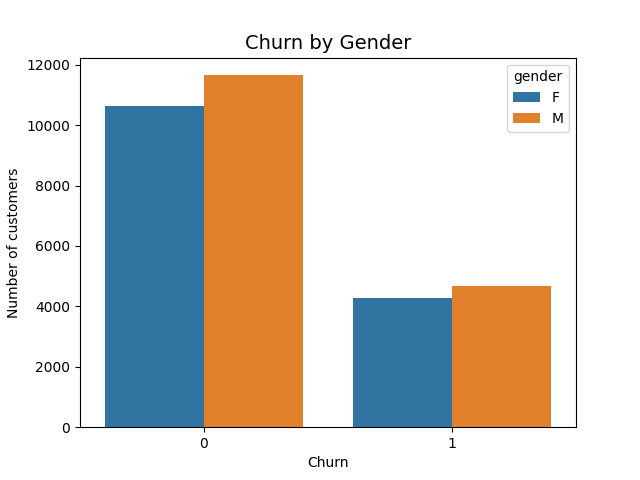

In [31]:
#gender distribution between regular and churn customers
churn_gen_pd = df.drop_duplicates(['userId', 'churn']).groupby(['churn', 'gender']).count().sort('churn').toPandas()

fig, ax=plt.subplots()


sns.barplot(x = 'churn', y = 'count',\
            data = churn_gen_pd, hue = 'gender')
ax.set_title('Churn by Gender', fontsize=14)
ax.set_xlabel('Churn')
ax.set_ylabel('Number of customers');
%matplot plt

Gender has a slight difference that males have churned more.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

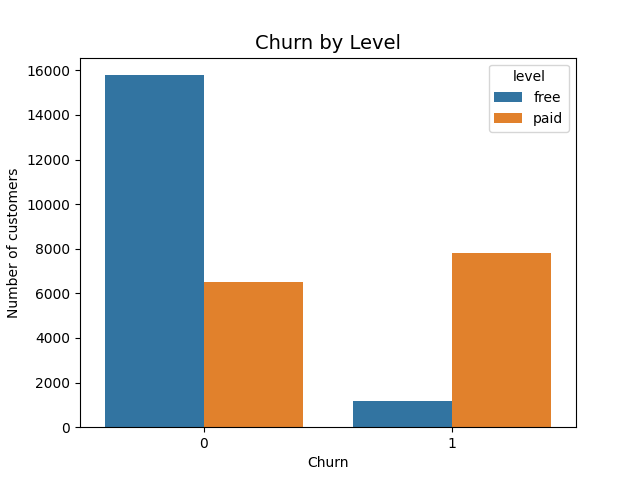

In [32]:
#level distribution between regular and churn customers
churn_gen_pd = df.drop_duplicates(['userId', 'churn']).groupby(['churn', 'level']).count().sort('churn').toPandas()

fig, ax=plt.subplots()

sns.barplot(x = 'churn', y = 'count',\
            data = churn_gen_pd, hue = 'level')
ax.set_title('Churn by Level', fontsize=14)
ax.set_xlabel('Churn')
ax.set_ylabel('Number of customers');
%matplot plt

**Note** There are about 8000 paid customers in churn in two months period, so it is a big deal in company's revenue.

In [33]:
# page visits by customers
df.groupby('page').agg(countDistinct('userId')).sort('page').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------------+
|                page|count(DISTINCT userId)|
+--------------------+----------------------+
|               About|                 14460|
|          Add Friend|                 20305|
|     Add to Playlist|                 21260|
|              Cancel|                  5003|
|Cancellation Conf...|                  5003|
|           Downgrade|                 15209|
|               Error|                 11272|
|                Help|                 18243|
|                Home|                 22072|
|              Logout|                 21160|
|            NextSong|                 22261|
|         Roll Advert|                 20068|
|       Save Settings|                 12237|
|            Settings|                 18933|
|    Submit Downgrade|                  5103|
|      Submit Upgrade|                 12082|
|         Thumbs Down|                 20031|
|           Thumbs Up|                 21732|
|             Upgrade|            

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

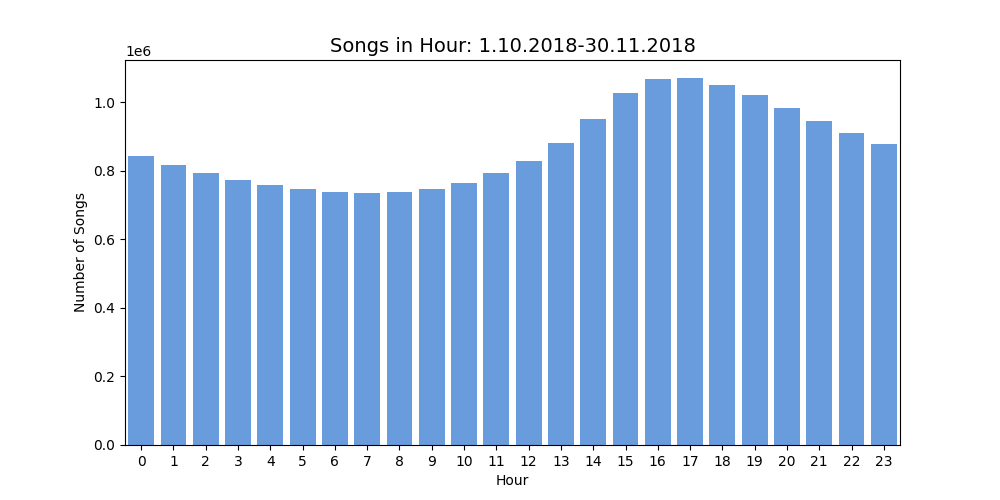

In [123]:
songs_in_hour = df.filter(df.page == 'NextSong').groupby(df.hour).count().orderBy(df.hour.cast('float')).toPandas()
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot( x='hour',y='count', data=songs_in_hour,ax=ax, color = '#549af0' )
ax.set_title('Songs in Hour: 1.10.2018-30.11.2018', fontsize=14)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Songs');
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

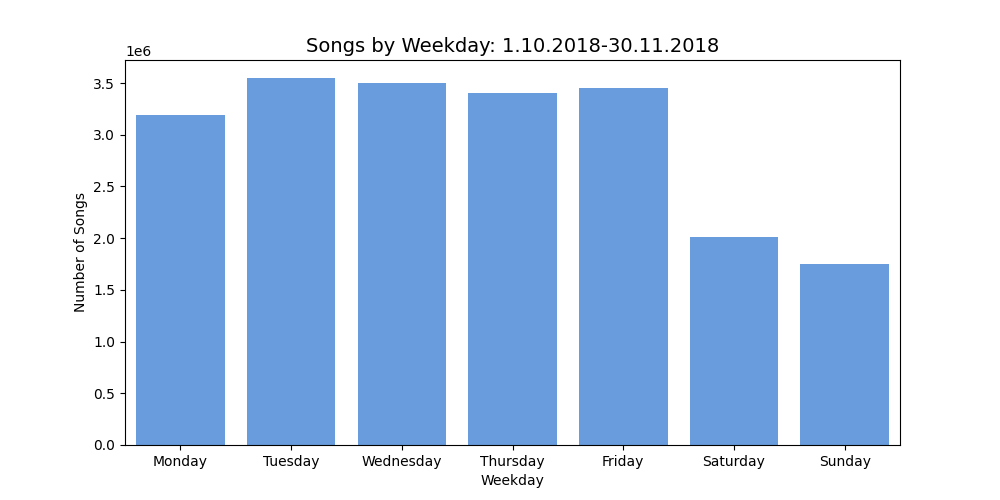

In [121]:
songs_in_day = df.filter(df.page == 'NextSong').groupby(df.weekday).count().orderBy(df.weekday).toPandas()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot( x='weekday',y='count', data=songs_in_day,ax=ax, order=days, color = '#549af0')
ax.set_title('Songs by Weekday: 1.10.2018-30.11.2018', fontsize=14)
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Songs');
%matplot plt

In [36]:
# split location variable to state
df = df.withColumn('state', split(col('location'),',').getItem(1))
states = df.dropDuplicates(['churn','userId'])\
.groupby(['state','churn']).count().sort('state').toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

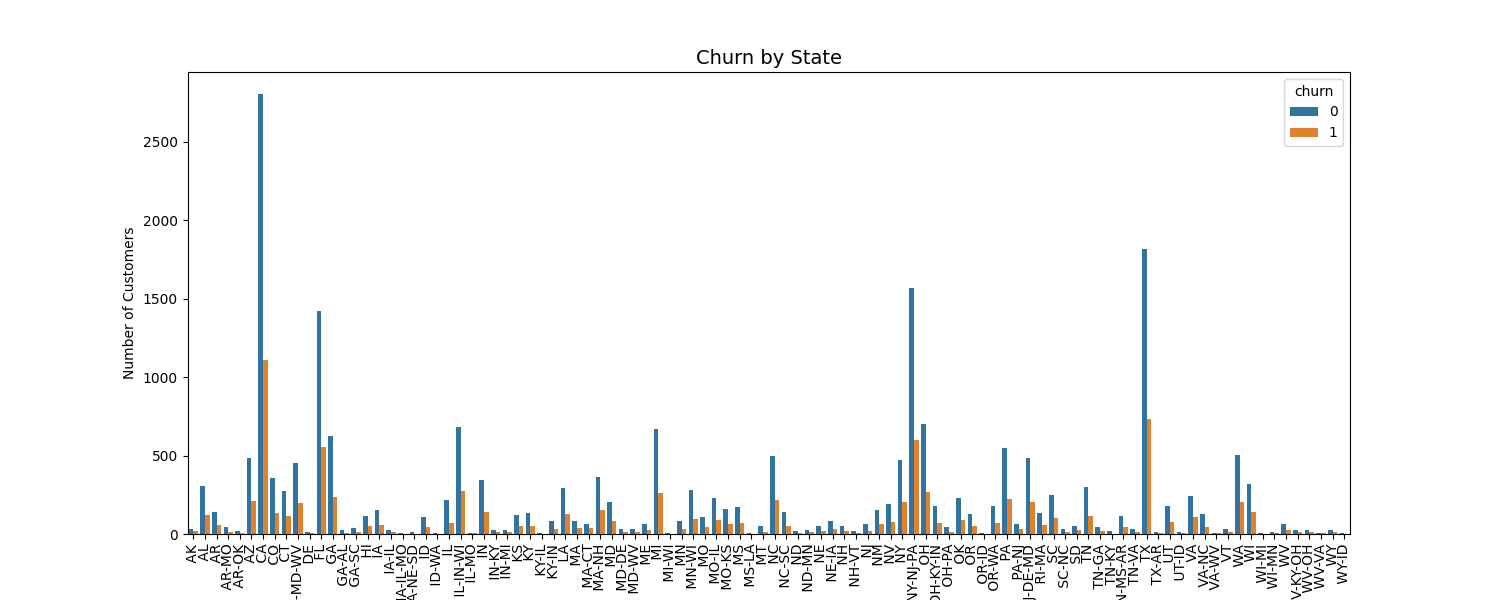

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Churned Customers by States ', fontsize=14)

sns.barplot( y="count",x="state", hue="churn", data=states,ax=ax)
ax.set_title('Churn by State', fontsize=14)
ax.set_xlabel('State')
ax.set_ylabel('Number of Customers');
plt.xticks(rotation=90);
%matplot plt

California, Texas, and New York Metropolitan Area have the largest count of customers and churned customers.

In [118]:
# load dataset for setting up ML pipeline
#df = spark.read.json('s3://<BUCKET_NAME>/df_clean/*.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# sessions duration per day per userId
day_session = df.groupby('userId','date','sessionId').\
    agg(F.max('ts').alias('end'), F.min('ts').alias('start')).\
    withColumn('day_session_duration', (col('end')-col('start'))*0.001)
day_session.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+---------+-------------+-------------+--------------------+
| userId|      date|sessionId|          end|        start|day_session_duration|
+-------+----------+---------+-------------+-------------+--------------------+
|1468899|2018-10-01|    20202|1538360036000|1538359845000|               191.0|
|1641605|2018-10-01|    24431|1538422492000|1538395108000|             27384.0|
|1472238|2018-10-01|     7331|1538434551000|1538405518000|             29033.0|
|1137339|2018-10-01|     5958|1538380244000|1538352038000|             28206.0|
|1368948|2018-10-01|    18238|1538370448000|1538352854000|             17594.0|
|1586302|2018-10-01|     4964|1538367196000|1538366763000|               433.0|
|1796178|2018-10-01|     1082|1538387216000|1538378432000|              8784.0|
|1754520|2018-10-01|    24097|1538406764000|1538392503000|             14261.0|
|1242753|2018-10-01|    24086|1538418125000|1538413239000|              4886.0|
|1052387|2018-10-01|     8046|1538354835

In [49]:
# max day session
day_session_max = day_session.agg({'day_session_duration': 'max'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+
|max(day_session_duration)|
+-------------------------+
|                  86397.0|
+-------------------------+

In [50]:
# max day session in hours
86397/3600

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

23.999166666666667

In [51]:
# daily sessions duration average per userId
daily_duration = df.groupby('userId','date','sessionId').\
    agg(F.max('ts').alias('end'), F.min('ts').alias('start')).\
    withColumn('session_duration', (col('end')-col('start'))*0.001).\
    groupby('userId','date').\
    avg('session_duration').\
    groupby('userId').\
    agg(round(F.avg('avg(session_duration)')).alias('daily_sec_avg')).\
    orderBy('daily_sec_avg', ascending=False)
daily_duration.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+
| userId|daily_sec_avg|
+-------+-------------+
|1685455|      72852.0|
|1815032|      71574.0|
|1867030|      63449.0|
|1945321|      63116.0|
|1133049|      62968.0|
|1788891|      61363.0|
|1005217|      60681.0|
|1032628|      59231.0|
|1242486|      57459.0|
|1645549|      57315.0|
|1021090|      57043.0|
|1382275|      56060.0|
|1947971|      54438.0|
|1366694|      54239.0|
|1368082|      54042.0|
|1435384|      52866.0|
|1730053|      51444.0|
|1358369|      49304.0|
|1840331|      48942.0|
|1578939|      48424.0|
+-------+-------------+
only showing top 20 rows

In [52]:
# sessions duration per month per userId
month_session = df.groupby('userId','month','sessionId').\
    agg(F.max('ts').alias('end'), F.min('ts').alias('start')).\
    withColumn('month_session_duration', (col('end')-col('start'))*0.001)
month_session.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+---------+-------------+-------------+----------------------+
| userId|month|sessionId|          end|        start|month_session_duration|
+-------+-----+---------+-------------+-------------+----------------------+
|1988133|   10|    28916|1538446214000|1538439164000|                7050.0|
|1497881|   10|    29657|1538511764000|1538470826000|               40938.0|
|1705753|   10|    23262|1538498012000|1538415557000|               82455.0|
|1382223|   10|    28050|1538446909000|1538422891000|               24018.0|
|1414878|   10|    27126|1538466082000|1538460929000|                5153.0|
|1788715|   10|    21231|1538468946000|1538461117000|                7829.0|
|1608368|   10|    25685|1538473860000|1538473860000|                   0.0|
|1425020|   10|     7097|1538489292000|1538487029000|                2263.0|
|1360863|   10|    24253|1538523057000|1538488634000|               34423.0|
|1984409|   10|    10175|1538435836000|1538428812000|                7024.0|

In [53]:
# monthly sessions duration average per userId
month_duration = df.groupby('userId','month','sessionId').\
    agg(F.max('ts').alias('end'), F.min('ts').alias('start')).\
    withColumn('session_duration', (col('end')-col('start'))*0.001).\
    groupby('userId','month').\
    avg('session_duration').\
    groupby('userId').\
    agg(round(F.avg('avg(session_duration)')).alias('month_sec_avg')).\
    orderBy('month_sec_avg', ascending=False)
month_duration.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+
| userId|month_sec_avg|
+-------+-------------+
|1815032|     143408.0|
|1272739|     142548.0|
|1151521|     136324.0|
|1788643|     125212.0|
|1334667|     120627.0|
|1021090|     114250.0|
|1382275|     112276.0|
|1719533|     111821.0|
|1839248|     111230.0|
|1730053|     107110.0|
|1483106|     102642.0|
|1005217|     101344.0|
|1788891|      99570.0|
|1578939|      97063.0|
|1872977|      94126.0|
|1379420|      94065.0|
|1502280|      93627.0|
|1073319|      92369.0|
|1835097|      92294.0|
|1221432|      89689.0|
+-------+-------------+
only showing top 20 rows

In [54]:
# registered days per users 2018-10-1 - 2018-11-30
reg_days = df.groupby('userId').agg(round(((F.max(unix_timestamp('timestamp')) - F.min(unix_timestamp('reg_timestamp')))/86400)).alias('reg_days'))
reg_days.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+
| userId|reg_days|
+-------+--------+
|1567623|   106.0|
|1271218|    87.0|
|1142513|   117.0|
|1492713|   127.0|
|1010669|   108.0|
|1816626|    10.0|
|1883991|    39.0|
|1031677|    25.0|
|1675930|    48.0|
|1720899|    33.0|
|1766909|    73.0|
|1660289|    55.0|
|1110773|    48.0|
|1529262|    73.0|
|1532612|    53.0|
|1193157|    82.0|
|1926200|    63.0|
|1008404|   111.0|
|1869054|    64.0|
|1615286|    49.0|
+-------+--------+
only showing top 20 rows

In [55]:
# active days per user 2018-10-1 - 2018-11-30
active_days = df.groupby('userId').agg(round(((F.max(unix_timestamp('timestamp')) - F.min(unix_timestamp('timestamp')))/86400)).alias('active_days'))
active_days.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+
| userId|active_days|
+-------+-----------+
|1390009|       25.0|
|1492713|       50.0|
|1114507|       60.0|
|1338783|       54.0|
|1010669|       60.0|
|1675930|       20.0|
|1430167|       13.0|
|1344069|       61.0|
|1926200|       61.0|
|1532612|       40.0|
|1008404|       39.0|
|1869054|       57.0|
|1110773|       32.0|
|1529262|       60.0|
|1193157|       60.0|
|1356571|       55.0|
|1205653|       40.0|
|1951644|       46.0|
|1524082|       16.0|
|1202075|       60.0|
+-------+-----------+
only showing top 20 rows

# 4. Feature Engineering
Next we build out the features we find promising to train our model on. After aggregating features by individual customers, I will also exam features by visuals and make some tests.

Selected features are:
- gender
- level of customer: paid or free
- sum of songs per customer
- sum of sessions per customer
- sum of lenght per customer
- sum of thumbs up given per customer
- sum of thumbs down given per customer
- sum of friends added per customer
- sum of songs added to playlist per customer
- sum of advertisments showed per customer
- sum of errors per customer
- sum of help page visited per customer
- average items in session per customer
- average session length per customer



I also took these features on that we can describe churned customers better:
- cancelleation confirmation
- submit downgrade
- sum_churn feature



In [57]:
# create user_df with aggregated features grouping by userId and aggregate features
# create new columns: cancelled, downgraded,sum_churn,sum_artists, sum_songs, sum_sessions, avg_items
# sum_lenght, avg_lenght, sum_tup, sum_tdown, sum_friend, sum_playlist, sum_advert,sum_help


user_df = df.groupby('userId')\
    .agg(
 # user_df features:
    first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
    first(when(col('level') == "paid", 1).otherwise(0)).alias('level'),
    F.sum(when(col('page') == "Cancellation Confirmation", 1).otherwise(0)).alias('cancelled'),
    F.sum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias('downgraded'),
    F.sum(when((col('cancelled')==1) | (col('downgraded')==1),1).otherwise(0)).alias('sum_churn'),
    F.sum(when(col('page') == "NextSong", 1).otherwise(0)).alias('sum_songs'),
    F.sum(when(col('sessionId')> 1, 1).otherwise(0)).alias('sum_sessions'),
    F.avg(when(col('itemInSession')> 1, 1).otherwise(0)).alias('avg_items'),
    F.sum(when(col('length')>1, 1).otherwise(0)).alias('sum_length'),
    F.avg(when(col('length')>1, 1).otherwise(0)).alias('avg_length'),
    F.sum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias('sum_tup'),
    F.sum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias('sum_tdown'),
    F.sum(when(col('page') == "Add Friend", 1).otherwise(0)).alias('sum_friend'),
    F.sum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias('sum_playlist'), 
    F.sum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias('sum_advert'),
    F.sum(when(col('page') == "Error", 1).otherwise(0)).alias('sum_errors'),
    F.sum(when(col('page') == "Help", 1).otherwise(0)).alias('sum_help'))




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# join previously created features registered and active days in user_df 
temp_df = reg_days.join(active_days,['userId'])
user_df = user_df.join(temp_df,['userId'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
# create new churn value 0 or 1 instead of sum of churn values
label = df.groupby('userId').agg(countDistinct('churn').alias('sum_churn')).dropDuplicates()
label = label.groupby('userId')\
    .agg(first(when(col('sum_churn') > 1, 1).otherwise(0)).alias('churn'))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# join label churn to user_df
user_df = user_df.join(label, ['userId'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
# now the whole dataset is ready for investigating features, so here is the last check for missing values
user_df.select([count(when(isnull(c), c)).alias(c) for c in user_df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------+-----+---------+----------+---------+---------+------------+---------+----------+----------+-------+---------+----------+------------+----------+----------+--------+--------+-----------+-----+
|userId|gender|level|cancelled|downgraded|sum_churn|sum_songs|sum_sessions|avg_items|sum_length|avg_length|sum_tup|sum_tdown|sum_friend|sum_playlist|sum_advert|sum_errors|sum_help|reg_days|active_days|churn|
+------+------+-----+---------+----------+---------+---------+------------+---------+----------+----------+-------+---------+----------+------------+----------+----------+--------+--------+-----------+-----+
|     0|     0|    0|        0|         0|        0|        0|           0|        0|         0|         0|      0|        0|         0|           0|         0|         0|       0|       0|          0|    0|
+------+------+-----+---------+----------+---------+---------+------------+---------+----------+----------+-------+---------+----------+------------+----------+--------

In [64]:
# checking rows of the dataset, count number is same as the individual customers
user_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22277

In [62]:
# all variations of customers who are in churn (1 = Female, 0 = Male)
churn = user_df.dropDuplicates(['userId', 'cancelled','downgraded','sum_churn']).groupby(['gender','cancelled','downgraded','sum_churn']).count().sort('sum_churn').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------+----------+---------+-----+
|gender|cancelled|downgraded|sum_churn|count|
+------+---------+----------+---------+-----+
|     1|        0|         0|        0| 6350|
|     0|        0|         0|        0| 6964|
|     1|        1|         0|        1| 1788|
|     1|        0|         1|        1| 1521|
|     0|        1|         0|        1| 2072|
|     0|        0|         1|        1| 1623|
|     1|        1|         1|        2|  431|
|     0|        1|         1|        2|  442|
|     1|        0|         2|        2|  330|
|     0|        0|         2|        2|  319|
|     0|        1|         2|        3|  109|
|     1|        0|         3|        3|   61|
|     1|        1|         2|        3|   89|
|     0|        0|         3|        3|   72|
|     1|        1|         3|        4|   36|
|     0|        1|         3|        4|   23|
|     1|        0|         4|        4|   11|
|     0|        0|         4|        4|   13|
|     0|        0|         5|     

As we can see in the table above, there are 1788 female and 2072 male customers who have canceled directly (not being downgraded first). This is the largest group in variations of churned customers with 3860 customers together.

sum of churn 1
The second biggest group of variations is customers who have downgraded once: 1521 female and 1623 male, together 3144 customers.

sum of churn 2
Customers who have downgraded once and canceled are 431 female and 442 male, together 873.

sum of churn 3–5
Some of the customers have downgraded 3 to 5 times and then canceled. This is not a big number of customers but would be interesting to search more. Customers in sum of churn group 3–5 together are: female 199, male 220

In [63]:
# save user_df copy for in case
#user_df.write.mode('overwrite').save('s3://<BUCKET_NAME>/user_df1.json', format='json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 5. Selecting features for Machine Learning

I will perform correlation matrix, explore diffrences, and z-test.  

In [67]:
# this dataset about 20k is easy to convert to Pandas data frame which 
# gives us easy options to make visuals
features_to_pd = user_df.select('userId','gender', 'level','sum_songs', 'sum_sessions','sum_length','sum_tup',\
                                'sum_tdown','sum_friend','sum_playlist','sum_advert',\
                                'sum_errors','sum_help','avg_items','avg_length','reg_days','active_days','churn')
features_pd = features_to_pd.toPandas() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

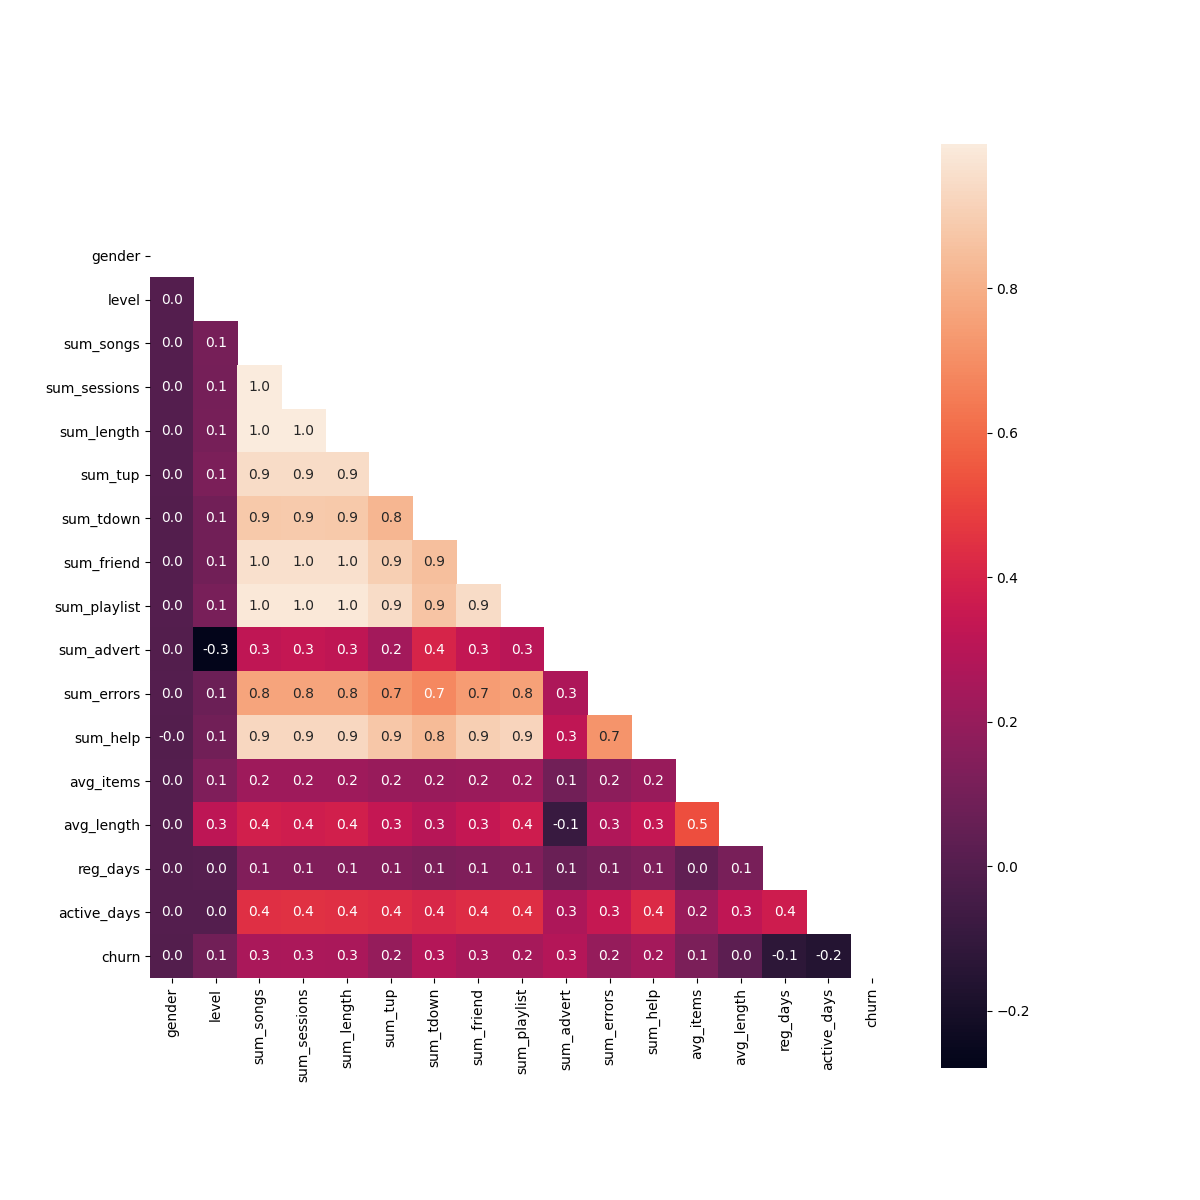

In [68]:
# create a correlation matrix
plt.figure(figsize=(12,12))#,facecolor='white')
corr = features_pd.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True, fmt='.1f', square=True, mask = mask);
%matplot plt

From the correlation matrix above we can see a high correlation between the sum of sessions, sum of length, sum of thumbs up, sum of help, and sum of a playlist. This is quite natural because this kind of active use of service correlates between.

Otherwise, we can see that level and gender have a weak correlation. Also, the correlation of the overall features between churned customers is weak. I will examine other differences next.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

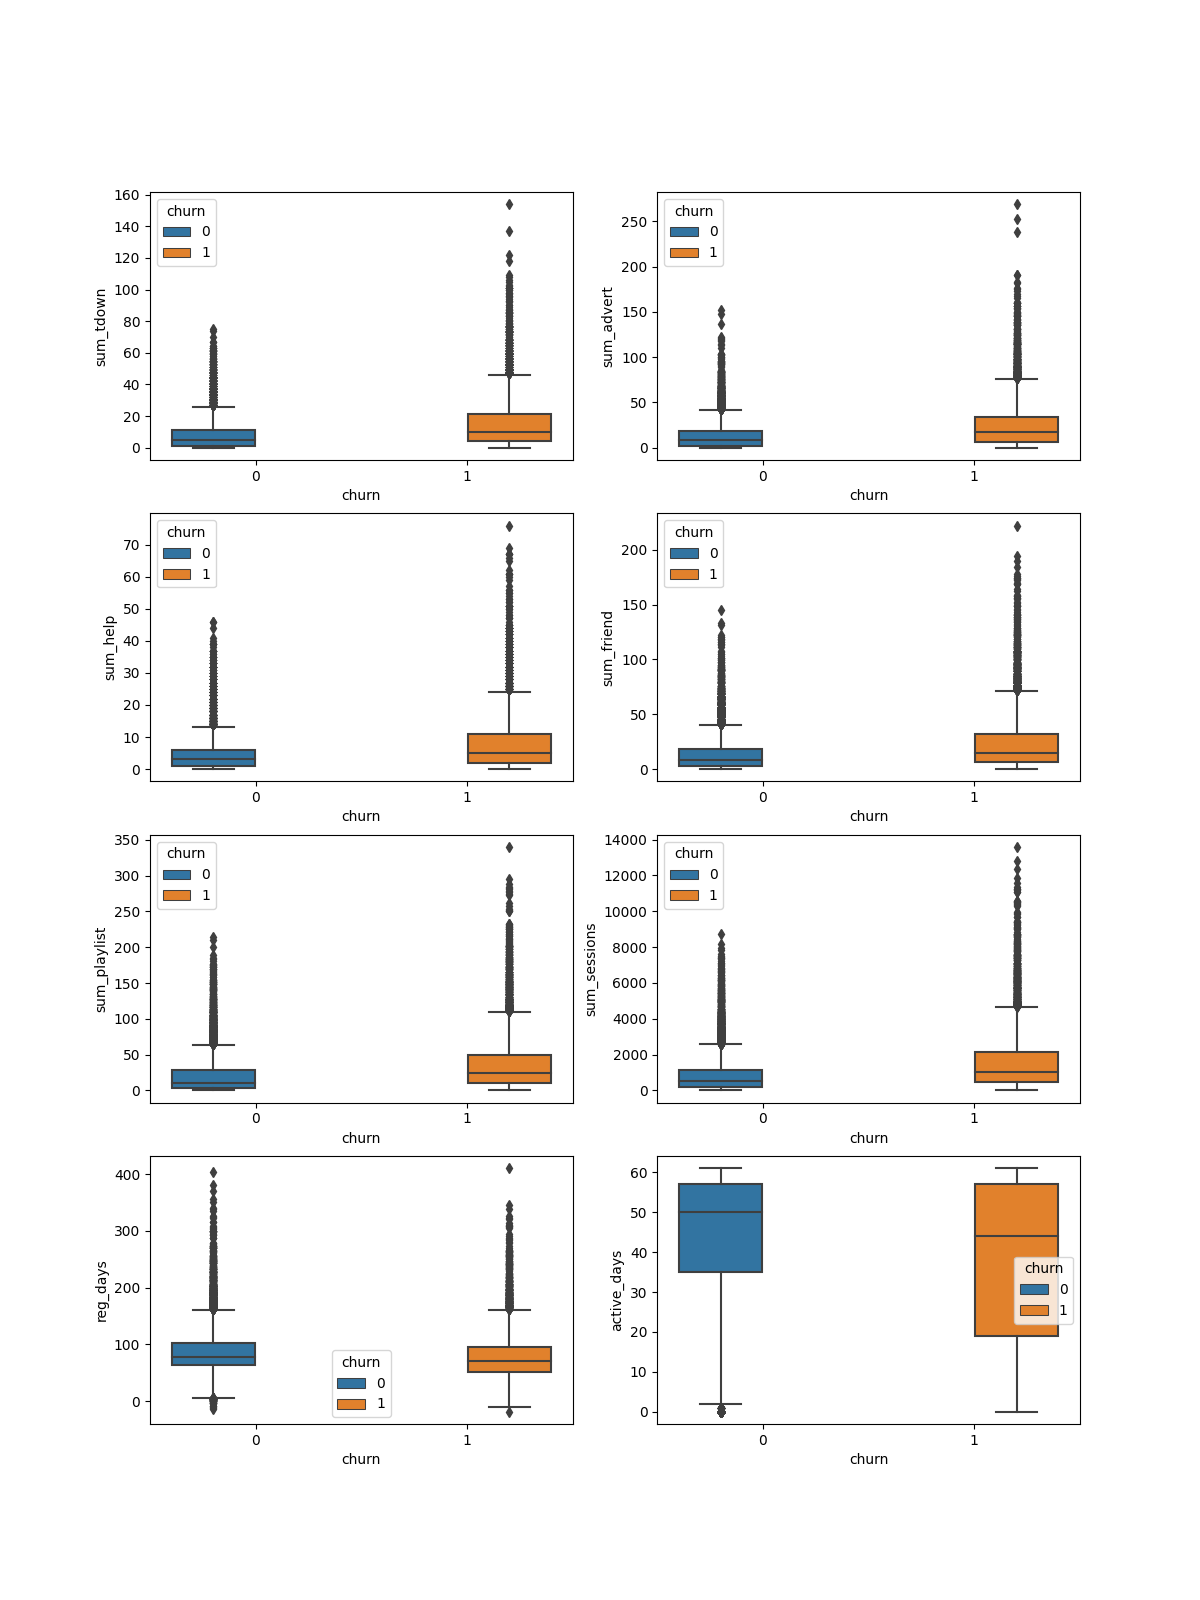

In [70]:
plt.figure(figsize=(12,16))#,facecolor='white')

plt.subplot(4,2,1)
sns.boxplot(x='churn',y='sum_tdown',hue='churn',data=features_pd)

plt.subplot(4,2,2)
sns.boxplot(x='churn',y='sum_advert',hue='churn',data=features_pd)

plt.subplot(4,2,3)
sns.boxplot(x='churn',y='sum_help',hue='churn',data=features_pd)

plt.subplot(4,2,4)
sns.boxplot(x='churn',y='sum_friend',hue='churn',data=features_pd)

plt.subplot(4,2,5)
sns.boxplot(x='churn',y='sum_playlist',hue='churn',data=features_pd)

plt.subplot(4,2,6)
sns.boxplot(x='churn',y='sum_sessions',hue='churn',data=features_pd)

plt.subplot(4,2,7)
sns.boxplot(x='churn',y='reg_days',hue='churn',data=features_pd)

plt.subplot(4,2,8)
sns.boxplot(x='churn',y='active_days',hue='churn',data=features_pd);
%matplot plt

From the graphs above we can notice some differences. The box plot range with customers who have not churned is more consistent, especially in the active day's plot. Form the box plots of the sum of thumbs down, the sum of advertisement and sum of help we can conduct, that these features have some impact to churn. We will see this in practice when we use machine learning models with enough data.

Next, a z-test will be performed for some features. Machine learning models will have their metrics, but I'm just testing as curiosity, how some features behave in z-test.

In [111]:
# load dataset for setting up ML pipeline
#user_df = spark.read.json('s3://<BUCKET_NAME>/user_df1.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [112]:
# function to make proportions of desired column for z-test
# testing desired column and churn
def z_test(col_name):
    
    a = user_df.dropDuplicates(['userId', col_name]).where((col(col_name) ==1) & (user_df.churn == 0)).groupby([col_name]).count().collect()[0][1]
    b = user_df.dropDuplicates(['userId', 'churn']).where((col(col_name) ==1) & (user_df.churn == 1)).groupby([col_name]).count().collect()[0][1]
    c = user_df.dropDuplicates(['userId', col_name]).where((col(col_name) ==0) & (user_df.churn == 0)).groupby([col_name]).count().collect()[0][1]
    d = user_df.dropDuplicates(['userId', 'churn']).where((col(col_name) ==0) & (user_df.churn == 1)).groupby([col_name]).count().collect()[0][1]
    e = d+c
    f = b+a
    
    result = proportions_ztest([d,b],[e,f],alternative='two-sided')
    print('The z-test score is:{}'.format(result))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [113]:
z_test('gender')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The z-test score is:(-0.01917321957973281, 0.9847029213546922)

In [114]:
z_test('level')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The z-test score is:(-12.877791715707222, 6.002862863310314e-38)

In [115]:
z_test('sum_tdown')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The z-test score is:(-2.3397021879056923, 0.019299122226508286)

In [116]:
z_test('sum_tup')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The z-test score is:(0.791601274890469, 0.4285932033269575)



After the correlation matrix, graphs of differences, and z-test, I decided to drop out from features variables gender and level. Also, I'm willing to keep other features even though some of them had weak correlations. A big dataset in machine learning might build a good model anyway.

# 6. Modeling

Splitting the full dataset into train, test, and validation sets. Testing out three machine learning models. Evaluating f1 score, the accuracy of the various models, and tuning parameters for the models. Determining the winning model based on test accuracy and report results on the validation set. 

I will build 3 models:

Logistic Regression Classifier

Random Forest Classifier

Gradient Boosted Tree Classifier



In [99]:
# load dataset for setting up ML pipeline
#user_df = spark.read.json('s3://<BUCKET_NAME>/user_df1.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
# checking columns and data types
user_df.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[active_days: double, avg_items: double, avg_length: double, cancelled: bigint, churn: bigint, downgraded: bigint, gender: bigint, level: bigint, reg_days: double, sum_advert: bigint, sum_churn: bigint, sum_errors: bigint, sum_friend: bigint, sum_help: bigint, sum_length: bigint, sum_playlist: bigint, sum_sessions: bigint, sum_songs: bigint, sum_tdown: bigint, sum_tup: bigint, userId: string]

In [100]:
# drop columns for ML as mentioned above 
user_df = user_df.drop('gender','level','sum_advert','userId', 'cancelled','downgraded','sum_churn')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Building a pipeline for models

In [101]:
# setting features, split dataset to train and test
features = [col for col in user_df.columns if col!='churn'] 

train, test = user_df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
def model_pipeline(clf, params):
    """
    Create features as vectors
    Standardize vectorized features
    Create a pipeline to build a ML models
    """
    assembler = VectorAssembler(inputCols=features, outputCol='vect_features')
    scaler = StandardScaler(inputCol='vect_features', outputCol='scaled_features',withStd = True)
    #scaler = MinMaxScaler(inputCol='vect_features1', outputCol='scaled_features1')
    pipeline = Pipeline(stages=[assembler, scaler, clf])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=3,
    )
    return model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [103]:
# evaluation metrics for ML models
def model_metrics(pred_model):
   
    evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',labelCol='churn')
    print('The metrics for the model:')
    print('The f1 Score is {}'.format(evaluator.evaluate(pred_model, {evaluator.metricName : 'f1'})))
    print('The accuracy is {}'.format(evaluator.evaluate(pred_model, {evaluator.metricName : 'accuracy'})))

    auc_evaluator = BinaryClassificationEvaluator(labelCol='churn')
    metric = auc_evaluator.evaluate(pred_model, {auc_evaluator.metricName: 'areaUnderROC'})
    print('The areaUnderROC: {:.2%}'.format(metric))
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### logistic regression classifier

In [81]:
# logistic regression classifier
mod1 = LogisticRegression(featuresCol='scaled_features', labelCol='churn')
mod1_param = ParamGridBuilder().build()
model_lr = model_pipeline(mod1, mod1_param)
# fit logistic regression 
cv_model_lr = model_lr.fit(train)
# predict logistic regression 
pred_lr = cv_model_lr.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### random forest classifier

In [83]:
# random forest classifier
mod2 = RandomForestClassifier(featuresCol='scaled_features', labelCol='churn')
mod2_param = ParamGridBuilder().build()
model_rf = model_pipeline(mod2, mod2_param)
# fit random forest
cv_model_rf = model_rf.fit(train)
# predict random forest
pred_rf = cv_model_rf.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### gradient boost classifier

In [84]:
# gradient boosted tree classifier
mod3 =GBTClassifier(featuresCol='scaled_features', labelCol='churn')
mod3_param = ParamGridBuilder().build()
model_gb = model_pipeline(mod3, mod3_param)
# fit gradient boost
cv_model_gb = model_gb.fit(train)
# predict gradient boost
pred_gb = cv_model_gb.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### metrics for the logistic regression classifier

In [85]:
# metrics for the logistic regression classifier
model_metrics(pred_lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The metrics for the model:
The f1 Score is 0.7314710495341883
The accuracy is 0.7375790424570913
The areaUnderROC: 78.87%

#### metrics for the random forrest classifier

In [86]:
# metrics for the random forrest classifier
model_metrics(pred_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The metrics for the model:
The f1 Score is 0.7325213185075448
The accuracy is 0.741869918699187
The areaUnderROC: 79.62%

#### metrics for the gradient boosted tree classifier

In [87]:
# metrics for the gradient boosted tree classifier
model_metrics(pred_gb)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The metrics for the model:
The f1 Score is 0.7585953466085313
The accuracy is 0.7624209575429087
The areaUnderROC: 82.81%

**Note** All of these models have good metrics even they are made by default settings. Next, these models will be tuned for the final ranking.

#### Tuning the logistic regression classifier

In [88]:
# tuning logistic regression classifier
# https://spark.apache.org/docs/latest/ml-tuning.html
lr_tuned = LogisticRegression(featuresCol='scaled_features', labelCol='churn')
param_grid_tuned_lr = ParamGridBuilder()\
    .addGrid(lr_tuned.regParam, [0.1, 0.01]) \
    .addGrid(lr_tuned.fitIntercept, [False, True])\
    .build()
    #.addGrid(lr_tuned.elasticNetParam, [0.0, 0.5, 1.0])\
    
model_lr_tuned = model_pipeline(lr_tuned, param_grid_tuned_lr)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
# fit tuned best logistic regression
cv_model_lr_tuned = model_lr_tuned.fit(train)
best_model = cv_model_lr_tuned.bestModel

# predict tuned best logistic regression
pred_best_model = best_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
# metrics for tuned best logistic regression classifier
model_metrics(pred_best_model)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The metrics for the model:
The f1 Score is 0.7221227065246013
The accuracy is 0.7299006323396567
The areaUnderROC: 77.53%

#### Tuning the random forest classifier

In [106]:
# tuning random forest classifier
def tune_pipeline(train, test, numTrees=[10,75], maxDepth=[5,20]):
    """
    Create features as vectors
    Standardize vectorized features
    Create a pipeline to build the random forest classifier
    """
    assembler = VectorAssembler(inputCols=features, outputCol='vect_features')
    scaler = StandardScaler(inputCol='vect_features', outputCol='scaled_features',withStd = True)
    #scaler = MinMaxScaler(inputCol='vect_features1', outputCol='scaled_features1')
    
    clf = RandomForestClassifier(featuresCol='scaled_features', labelCol='churn')
    

        
    param_grid_tuned = ParamGridBuilder()\
    .addGrid(clf.numTrees,numTrees)\
    .addGrid(clf.maxDepth,maxDepth).build()

    mod = CrossValidator(
        estimator = Pipeline(stages=[assembler,scaler, clf]),
        estimatorParamMaps=param_grid_tuned,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=3,
    )
    
    cvModel = mod.fit(train)
    predictions = cvModel.transform(test)
    
    model_metrics(predictions)
    
    bestPipeline = cvModel.bestModel
    
    # print importances of features
    for i in range(len(bestPipeline.stages[2].featureImportances)):
        print("{} : {} \n".format(features[i], bestPipeline.stages[2].featureImportances[i]))
    
    print('Best parameters : max depth:{}, num Trees:{}'.\
          format(bestPipeline.stages[2].getOrDefault('maxDepth'), bestPipeline.stages[2].getNumTrees))
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
tune_pipeline(train,test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The metrics for the model:
The f1 Score is 0.7649560407391017
The accuracy is 0.7685185185185185
The areaUnderROC: 82.94%
active_days : 0.17399743987396252 

avg_items : 0.09154393124396465 

avg_length : 0.09657002910326234 

reg_days : 0.11004459427580472 

sum_errors : 0.03248889617060959 

sum_friend : 0.06471308279798062 

sum_help : 0.05280599430081901 

sum_length : 0.046876995591892644 

sum_playlist : 0.05428894890305349 

sum_sessions : 0.06284010779119717 

sum_songs : 0.042276255878755366 

sum_tdown : 0.1040576598865753 

sum_tup : 0.06749606418212248 

Best parameters : max depth:20, num Trees:75

#### Tuning the gradient boosted tree classifier

In [108]:
# tuning gradient boosted tree classifier
gb_tuned = GBTClassifier(featuresCol='scaled_features', labelCol='churn', seed = 42)

param_grid_tuned_gb = ParamGridBuilder().\
addGrid(gb_tuned.maxIter, [10, 15, 20])\
.addGrid(gb_tuned.maxDepth, [5, 10]).build()

model_gb_tuned = model_pipeline(gb_tuned, param_grid_tuned_gb)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [109]:
# fit tuned gradient boosted tree classifier
cv_model_gb_tuned = model_gb_tuned.fit(train)
best_model_gb = cv_model_gb_tuned.bestModel

# predict tuned best gradient boosted tree classifier
pred_best_model_gb = best_model_gb.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
# metrics for tuned best gradient boosted tree classifier
model_metrics(pred_best_model_gb)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The metrics for the model:
The f1 Score is 0.753220262022058
The accuracy is 0.757226738934056
The areaUnderROC: 82.53%

# 7. Conclusions

Logistic regression classifier, random forest classifier, and gradient boosted tree classifier had good metrics. Hyperparameter tuning helped the random forest classifier be the winner. Metrics were:

The f1 Score is 0.7649560407391017
The accuracy is 0.7685185185185185
The areaUnderROC: 82.94%

The features importances showed that registration days and active days have an impact on churned customers. These features should be evaluated in the future, that we could engineer other time-based variables such as days when downgraded and days when upgraded. Clearly, an independent feature that metrics churn is clicking thumbs down. This should be analyzed in the streaming version of the prediction machine that we could deploy in production soon.